In [2]:
import numpy as np
import pandas as pd

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Time
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other models
import xgboost as xgb

# Conversions
import re

/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Options
sns.set_style('darkgrid')
pd.set_option('display.precision', 2)
plt.rcParams['figure.figsize'] = (10, 5)

In [4]:
features = pd.read_csv('/Users/anastasiamalakhova/Desktop/Walmart data/walmart-recruiting-store-sales-forecasting/features.csv')
stores = pd.read_csv('/Users/anastasiamalakhova/Desktop/Walmart data/walmart-recruiting-store-sales-forecasting/stores.csv')
dataset = pd.read_csv('/Users/anastasiamalakhova/Desktop/Walmart data/walmart-recruiting-store-sales-forecasting/train.csv')

### EDA of stores

In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [7]:
for column in stores.columns:
    print(column, stores[column].nunique())

Store 45
Type 3
Size 40


No missing data

In [8]:
for column in stores.columns:
    print(column, stores[column].isnull().sum())

Store 0
Type 0
Size 0


In [9]:
stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [10]:
stores['Type'].value_counts()
# Imbalanced data with respect to stores

A    22
B    17
C     6
Name: Type, dtype: int64

In [11]:
# We don't seem to have outliers with respect to size
stores['Size'].sort_values().unique()

array([ 34875,  37392,  39690,  39910,  41062,  42988,  57197,  70713,
        93188,  93638, 103681, 112238, 114533, 118221, 119557, 120653,
       123737, 125833, 126512, 128107, 140167, 151315, 152513, 155078,
       155083, 158114, 184109, 196321, 200898, 202307, 202505, 203007,
       203742, 203750, 203819, 204184, 205863, 206302, 207499, 219622])

### EDA of features - to combine later in the process

In [12]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,2010-02-12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True
2,1,2010-02-19,39.93,2.51,NaN,NaN,NaN,NaN,NaN,211.29,8.11,False
3,1,2010-02-26,46.63,2.56,NaN,NaN,NaN,NaN,NaN,211.32,8.11,False
4,1,2010-03-05,46.50,2.62,NaN,NaN,NaN,NaN,NaN,211.35,8.11,False


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [14]:
features['Unemployment'].nunique()

404

In [15]:
for column in features.columns:
    print(column, features[column].isnull().sum())

Store 0
Date 0
Temperature 0
Fuel_Price 0
MarkDown1 4158
MarkDown2 5269
MarkDown3 4577
MarkDown4 4726
MarkDown5 4140
CPI 585
Unemployment 585
IsHoliday 0


In [16]:
features['MarkDown1'].nunique()

4023

In [17]:
price_reductions = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

for element in price_reductions:
    print(features[features['IsHoliday'] == True][element].isnull().sum())

271
318
286
301
270


In [18]:
np.sort(features['Date'].unique())

array(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
       '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
       '2010-04-02', '2010-04-09', '2010-04-16', '2010-04-23',
       '2010-04-30', '2010-05-07', '2010-05-14', '2010-05-21',
       '2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18',
       '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16',
       '2010-07-23', '2010-07-30', '2010-08-06', '2010-08-13',
       '2010-08-20', '2010-08-27', '2010-09-03', '2010-09-10',
       '2010-09-17', '2010-09-24', '2010-10-01', '2010-10-08',
       '2010-10-15', '2010-10-22', '2010-10-29', '2010-11-05',
       '2010-11-12', '2010-11-19', '2010-11-26', '2010-12-03',
       '2010-12-10', '2010-12-17', '2010-12-24', '2010-12-31',
       '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28',
       '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25',
       '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25',
       '2011-04-01', '2011-04-08', '2011-04-15', '2011-

### EDA dataset

In [19]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [21]:
for column in dataset.columns:
    print(column, dataset[column].nunique())

Store 45
Dept 81
Date 143
Weekly_Sales 359464
IsHoliday 2


In [22]:
# No missing values
for column in dataset.columns:
    print(column, dataset[column].isnull().sum())

Store 0
Dept 0
Date 0
Weekly_Sales 0
IsHoliday 0


In [23]:
print(dataset['Store'].unique())
print(dataset['Dept'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]


In [24]:
unique_types = set(type(x) for x in dataset['Date'])
print(unique_types)

{<class 'str'>}


In [25]:
unique_types = set(type(x) for x in dataset['Weekly_Sales'])
print(unique_types)

{<class 'float'>}


In [26]:
np.sort(dataset['Weekly_Sales'])

array([ -4988.94,  -3924.  ,  -1750.  , ..., 630999.19, 649770.18,
       693099.36])

In [27]:
# The upper boundary is fine
np.sort(dataset['Weekly_Sales'])[-10:]

array([393705.2 , 404245.03, 406988.63, 420586.57, 422306.25, 474330.1 ,
       627962.93, 630999.19, 649770.18, 693099.36])

In [28]:
# Need to exclude negative numbers
np.sort(dataset['Weekly_Sales'])[:20]

array([-4988.94, -3924.  , -1750.  , -1699.  , -1321.48, -1098.  ,
       -1098.  , -1098.  , -1008.96,  -898.  ,  -863.  ,  -798.  ,
        -798.  ,  -798.  ,  -798.  ,  -778.5 ,  -771.9 ,  -705.  ,
        -698.  ,  -698.  ])

In [29]:
dataset = dataset[dataset['Weekly_Sales'] >= 0]

In [30]:
print(dataset[dataset['Weekly_Sales'] == 0])
print(len(dataset[dataset['Weekly_Sales'] == 0]))

        Store  Dept        Date  Weekly_Sales  IsHoliday
6055        1    47  2011-03-11           0.0      False
6059        1    47  2011-08-12           0.0      False
6060        1    47  2011-08-19           0.0      False
16309       2    47  2012-04-13           0.0      False
17457       2    60  2010-03-19           0.0      False
...       ...   ...         ...           ...        ...
403340     43    85  2012-01-13           0.0      False
407652     44    27  2011-01-14           0.0      False
417805     45    47  2011-02-11           0.0       True
418079     45    54  2010-10-15           0.0      False
418150     45    54  2012-08-31           0.0      False

[73 rows x 5 columns]
73


Dealing with date

In [31]:
dataset['Date'] = dataset['Date'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))
dataset['year'] = dataset['Date'].apply(lambda _: _.year)
dataset['month'] = dataset['Date'].apply(lambda _: _.month)
dataset['day_of_month'] = dataset['Date'].apply(lambda _: _.day)
dataset['weekday'] = dataset['Date'].apply(lambda _: _.weekday())

In [32]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month,weekday
0,1,1,2010-02-05,24924.50,False,2010,2,5,4
1,1,1,2010-02-12,46039.49,True,2010,2,12,4
2,1,1,2010-02-19,41595.55,False,2010,2,19,4
3,1,1,2010-02-26,19403.54,False,2010,2,26,4
4,1,1,2010-03-05,21827.90,False,2010,3,5,4


In [33]:
columns = ['year','month','day_of_month','weekday']

for column in columns:
    print(column, np.sort(dataset[column].unique()))

# It seems like we only measure sales every Thursday

year [2010 2011 2012]
month [ 1  2  3  4  5  6  7  8  9 10 11 12]
day_of_month [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
weekday [4]


### Visual representation of the dataset

In [34]:
dataset['year'].value_counts()

2011    152970
2010    140289
2012    127026
Name: year, dtype: int64

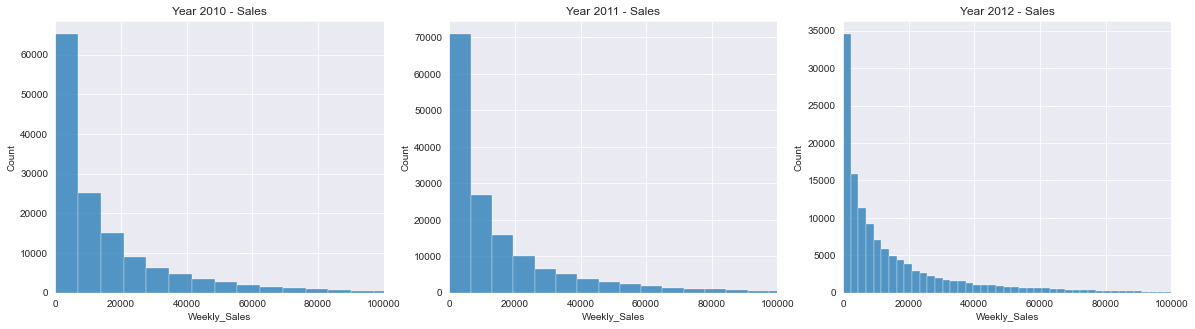

In [35]:
# We can see a log-normal trend
plot_data_2010 = dataset[dataset['year'] == 2010]
plot_data_2011 = dataset[dataset['year'] == 2011]
plot_data_2012 = dataset[dataset['year'] == 2012]


plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
sns.histplot(data = plot_data_2010, x = 'Weekly_Sales', bins = 100)
plt.title('Year 2010 - Sales')
plt.xlim(0, 100000)
plt.xlabel('Weekly_Sales')
plt.subplot(1,3,2)
sns.histplot(data = plot_data_2011, x = 'Weekly_Sales', bins = 100)
plt.title('Year 2011 - Sales')
plt.xlim(0, 100000)
plt.xlabel('Weekly_Sales')
plt.subplot(1,3,3)
sns.histplot(data = plot_data_2012, x = 'Weekly_Sales', bins = 100)
plt.title('Year 2012 - Sales')
plt.xlim(0, 100000)
plt.xlabel('Weekly_Sales')
plt.show()

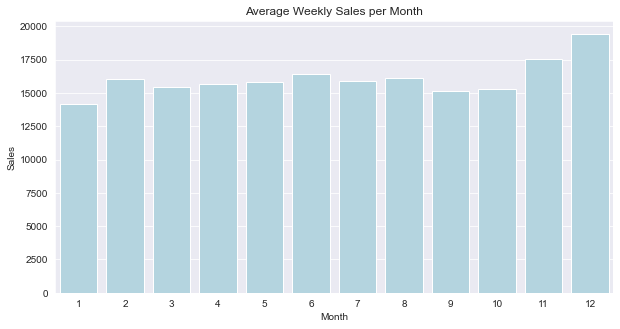

In [36]:
# Makes sense that there is more sales just before Christmas
month_sls = dataset.groupby('month')['Weekly_Sales'].mean()

plt.figure(figsize = (10,5))
sns.barplot(x = month_sls.index, y = month_sls.values, color = 'lightblue')
plt.title('Average Weekly Sales per Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

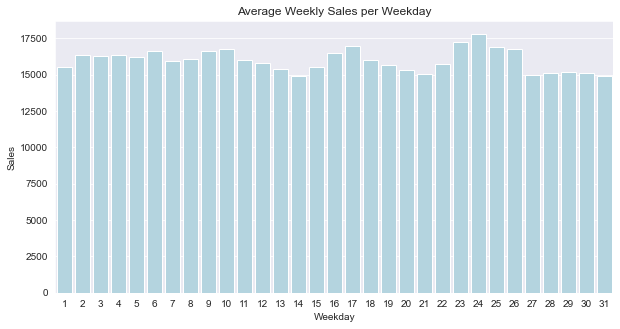

In [37]:
# Makes sense that there is not much explanatory power in the day of the month
weekday_sls = dataset.groupby('day_of_month')['Weekly_Sales'].mean()

plt.figure(figsize = (10,5))
sns.barplot(x = weekday_sls.index, y = weekday_sls.values, color = 'lightblue')
plt.title('Average Weekly Sales per Weekday')
plt.xlabel('Weekday')
plt.ylabel('Sales')
plt.show()

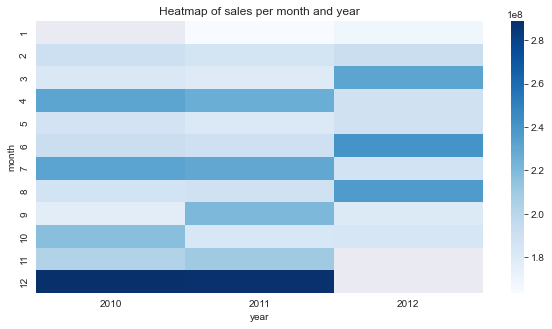

In [38]:
plt.figure(figsize=(10, 5))
sns.heatmap(dataset.groupby(['month', 'year'])['Weekly_Sales'].sum().unstack(), cmap='Blues')
plt.title('Heatmap of sales per month and year')
plt.show()

### Merging data

In [39]:
dataset.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month,weekday
0,1,1,2010-02-05,24924.50,False,2010,2,5,4
1,1,1,2010-02-12,46039.49,True,2010,2,12,4


In [40]:
features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,2010-02-12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True


In [41]:
stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [42]:
# Adding type and size
data = pd.merge(stores, dataset, on = 'Store', how = 'left')
data.head(2)

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month,weekday
0,1,A,151315,1,2010-02-05,24924.50,False,2010,2,5,4
1,1,A,151315,1,2010-02-12,46039.49,True,2010,2,12,4


In [43]:
len(dataset) == len(data)

True

In [44]:
len(data)

420285

In [45]:
# Adding features
data['Date'] = pd.to_datetime(data['Date'])
features['Date'] = pd.to_datetime(features['Date'])
data = pd.merge(data, features, on=['Store', 'Date'], how='left')

In [46]:
len(data)

420285

In [47]:
data.head(2)

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday_x,year,month,day_of_month,...,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,A,151315,1,2010-02-05,24924.50,False,2010,2,5,...,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,A,151315,1,2010-02-12,46039.49,True,2010,2,12,...,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True


In [48]:
# Are the two columsn identical?
np.sum(data['IsHoliday_x'] == data['IsHoliday_y'])-len(data)

0

In [49]:
data.drop('IsHoliday_y', axis = 1, inplace = True)
data.rename(columns = {'IsHoliday_x':'IsHoliday'}, inplace = True)

In [50]:
data.head(2)

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month,weekday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,A,151315,1,2010-02-05,24924.50,False,2010,2,5,4,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
1,1,A,151315,1,2010-02-12,46039.49,True,2010,2,12,4,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11


In [51]:
# Weekday is the same, so we can drop it
data.drop('weekday', axis = 1, inplace = True)
data.head(2)

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,A,151315,1,2010-02-05,24924.50,False,2010,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
1,1,A,151315,1,2010-02-12,46039.49,True,2010,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11


Because we will be using the model on the future data, we shouldn't take into account 'year' variable

In [52]:
data.drop(['year','Date'], axis = 1, inplace = True)
data.head(2)

,Store,Type,Size,Dept,Weekly_Sales,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,A,151315,1,24924.50,False,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
1,1,A,151315,1,46039.49,True,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11


### Benchmark model - Linear Regression

In [53]:
data.reset_index(inplace = True, drop = True)

In [54]:
# print the number of missing values in each column
for column in data.columns:
    print(column, data[column].isnull().sum())

Store 0
Type 0
Size 0
Dept 0
Weekly_Sales 0
IsHoliday 0
month 0
day_of_month 0
Temperature 0
Fuel_Price 0
MarkDown1 270085
MarkDown2 309367
MarkDown3 283618
MarkDown4 285750
MarkDown5 269337
CPI 0
Unemployment 0


In [55]:
# Let's make a very simple model that will act as a lower benchmark
X = data[['Store', 'Type','Size','Dept','IsHoliday','month','day_of_month','Temperature','Fuel_Price','CPI','Unemployment']].copy()
y = data['Weekly_Sales'].copy()

In [56]:
# create dummy variables
X = pd.get_dummies(X, columns = ['Store', 'Type','Dept','IsHoliday','month','day_of_month'], drop_first = True)

In [57]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

(array([  6731.,  86645., 137106.,  95134.,  44156.,  21604.,  12561.,
          9043.,   5838.,   1467.]),
 array([-21085.58553212,  -9424.01055237,   2237.56442738,  13899.13940713,
         25560.71438688,  37222.28936663,  48883.86434638,  60545.43932613,
         72207.01430588,  83868.58928563,  95530.16426538]),
 <BarContainer object of 10 artists>)

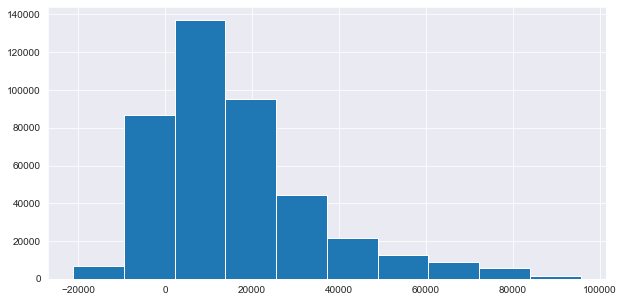

In [58]:
y_fitted = model.predict(X)
plt.hist(y_fitted)

We want a log-transformation of the target variable because all output should be positive

In [59]:
# Add 1 because we can't have 0 with log
y_log = np.log(y + 1)
model.fit(X, y_log)
y_fitted_log = model.predict(X)
y_fitted = np.exp(y_fitted_log) - 1

(-1000.0, 100000.0)

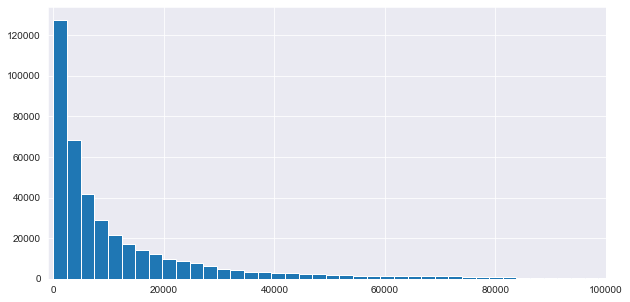

In [60]:
plt.hist(y_fitted, bins = 100)
plt.xlim(-1000, 100000)

In [61]:
# Weighted mean absolute error
def wmae(y, y_pred, weights):
    return np.sum(weights * np.abs(y - y_pred)) / np.sum(weights)

In [62]:
# w = 5 if the week is a holiday week, 1 otherwise
df = pd.DataFrame({'y_true': y, 'y_pred': y_fitted, 'weights': np.where(data['IsHoliday'] == True, 5, 1)}) 
#df = df[df['y_true'] != 0]

y_true = df['y_true']
y_pred = df['y_pred']
weights = df['weights']

In [63]:
wmae_error = wmae(y_true, y_pred, weights).round(2)
print("LR WMAE: {:,.0f}".format(wmae_error))

LR WMAE: 7,307


In [64]:
lr_error = mean_squared_error(y_true, y_pred)
print("LR MSE: {:,.0f}".format(lr_error))

LR MSE: 202,008,264


### More complex models - XGBoosting

In [65]:
data.head(2)

,Store,Type,Size,Dept,Weekly_Sales,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,A,151315,1,24924.50,False,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
1,1,A,151315,1,46039.49,True,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11


In [66]:
# Add weight to the data
data['weights'] = np.where(data['IsHoliday'] == True, 5, 1)

In [67]:
data.head(2)

,Store,Type,Size,Dept,Weekly_Sales,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,weights
0,1,A,151315,1,24924.50,False,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,1
1,1,A,151315,1,46039.49,True,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,5


In [68]:
X = data.copy()
X.drop(['Weekly_Sales'], axis=1, inplace=True)
y = data['Weekly_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

We will not create any interaction terms because the model should be able to capture those

In [69]:
X_train.head(2)

,Store,Type,Size,Dept,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,weights
102438,11,A,207499,36,False,9,17,83.04,2.58,NaN,NaN,NaN,NaN,NaN,214.83,7.35,1
406749,44,C,39910,32,False,2,25,33.17,3.12,NaN,NaN,NaN,NaN,NaN,128.13,7.22,1


In [70]:
X_train = pd.get_dummies(X_train, columns = ['Store','Type','Dept','IsHoliday','month','day_of_month'], drop_first = True)
X_val = pd.get_dummies(X_val, columns = ['Store','Type','Dept','IsHoliday','month','day_of_month'], drop_first = True)

In [80]:
X_train.head(2)

,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
102438,207499,83.04,2.58,NaN,NaN,NaN,NaN,NaN,214.83,7.35,...,0,0,0,0,0,0,0,0,0,0
406749,39910,33.17,3.12,NaN,NaN,NaN,NaN,NaN,128.13,7.22,...,0,0,0,1,0,0,0,0,0,0


We will use higher depth than 2, because there are interdependencies in the data

In [81]:
# Create X_train_boosting same as X_train but without weights
X_train_boosting = X_train.copy()
X_train_boosting.drop('weights', axis = 1, inplace = True)

In [82]:
# With log - because XGBoosting fits any new model on the pseudo residuals of the previous model, and hence it can result in negative value output
y_train_log = np.log(y_train + 1)

param_grid = {'n_estimators': [100, 300, 500, 900],
              'learning_rate': [0.1, 0.5, 0.7, 0.9],
              'max_depth': [2, 3, 5, 7, 9]}

model = xgb.XGBRegressor(seed = 42, 
                         booster = 'gbtree',
                         objective = 'reg:squarederror',
                         tree_method = 'hist')

grid_search = GridSearchCV(estimator= model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_boosting, y_train_log)

best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

{'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 900}

In [83]:
# With log
y_train_log = np.log(y_train + 1)

model = xgb.XGBRegressor(seed=42, 
                         booster = 'gbtree', 
                         objective = 'reg:squarederror', 
                         tree_method = 'hist',
                         learning_rate = 0.5, 
                         n_estimators = 900,
                         max_depth = 7)

# drop weights for training
model.fit(X_train_boosting, y_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='hist', validate_parameters=1,
             verbosity=None)

In [119]:
X_val_boosting = X_val.copy()
X_val_boosting.drop('weights', axis = 1, inplace = True)

y_log_fitted = model.predict(X_val_boosting)
y_fitted = np.exp(y_log_fitted) - 1

xgb_error = mean_squared_error(y_val, y_fitted)
print("XGBoost MSE: {:,.0f}".format(xgb_error))

XGBoost MSE: 34,698,770


/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [120]:
X_val

,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
380743,196321,16.81,3.04,NaN,NaN,NaN,NaN,NaN,191.86,7.24,...,0,0,0,0,0,0,0,0,0,0
390528,39690,74.04,4.20,NaN,NaN,NaN,NaN,NaN,129.09,8.49,...,0,0,0,0,0,0,0,0,0,0
267643,206302,47.87,2.95,NaN,NaN,NaN,NaN,NaN,126.50,13.97,...,0,0,0,0,0,0,0,0,0,0
359345,39690,88.95,3.90,NaN,NaN,NaN,NaN,NaN,129.07,13.74,...,0,0,1,0,0,0,0,0,0,0
25358,37392,88.44,3.55,NaN,NaN,NaN,NaN,NaN,219.02,7.57,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93354,126512,60.68,3.76,174.72,329.00,141630.61,79.00,1009.98,129.84,7.87,...,0,0,0,1,0,0,0,0,0,0
403892,39910,77.62,3.57,NaN,NaN,NaN,NaN,NaN,129.17,6.56,...,0,0,0,0,0,0,0,1,0,0
1916,151315,62.76,3.49,NaN,NaN,NaN,NaN,NaN,214.36,7.74,...,0,0,0,0,0,0,0,0,0,0
97214,126512,77.02,4.06,18275.88,NaN,21.31,4872.45,2722.29,131.14,7.38,...,0,0,0,0,0,0,0,0,0,0


In [121]:
df = pd.DataFrame({'y_true': y_val, 'y_pred': y_fitted, 'weights': X_val['weights']}) 

y_true = df['y_true']
y_pred = df['y_pred']
weights = df['weights']

wmae_error = wmae(y_true, y_pred, weights).round(2)
print("XGBoosting WMAE: {:,.0f}".format(wmae_error))

XGBoosting WMAE: 2,730


### Creating a test fine

In [124]:
test = pd.read_csv('/Users/anastasiamalakhova/Desktop/Walmart data/walmart-recruiting-store-sales-forecasting/test.csv')
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [125]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [126]:
test['Date'] = test['Date'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))
test['month'] = test['Date'].apply(lambda _: _.month)
test['day_of_month'] = test['Date'].apply(lambda _: _.day)

In [127]:
test.head()

,Store,Dept,Date,IsHoliday,month,day_of_month
0,1,1,2012-11-02,False,11,2
1,1,1,2012-11-09,False,11,9
2,1,1,2012-11-16,False,11,16
3,1,1,2012-11-23,True,11,23
4,1,1,2012-11-30,False,11,30


Marging data together

In [128]:
test_data = pd.merge(stores, test, on = 'Store', how = 'left')

test_data['Date'] = pd.to_datetime(test_data['Date'])
features['Date'] = pd.to_datetime(features['Date'])

test_data = pd.merge(test_data, features, on=['Store', 'Date'], how='left')

In [129]:
test_data.head()

,Store,Type,Size,Dept,Date,IsHoliday_x,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,A,151315,1,2012-11-02,False,11,2,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,False
1,1,A,151315,1,2012-11-09,False,11,9,61.24,3.31,11421.32,3370.89,40.28,4646.79,6154.16,223.48,6.57,False
2,1,A,151315,1,2012-11-16,False,11,16,52.92,3.25,9696.28,292.10,103.78,1133.15,6612.69,223.51,6.57,False
3,1,A,151315,1,2012-11-23,True,11,23,56.23,3.21,883.59,4.17,74910.32,209.91,303.32,223.56,6.57,True
4,1,A,151315,1,2012-11-30,False,11,30,52.34,3.21,2460.03,NaN,3838.35,150.57,6966.34,223.61,6.57,False


In [130]:
test_data.drop(['Date','IsHoliday_y'], axis = 1, inplace = True)
test_data.rename(columns = {'IsHoliday_x':'IsHoliday'}, inplace = True)

In [131]:
test_data.head(2)

,Store,Type,Size,Dept,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,A,151315,1,False,11,2,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57
1,1,A,151315,1,False,11,9,61.24,3.31,11421.32,3370.89,40.28,4646.79,6154.16,223.48,6.57


In [132]:
test_data = pd.get_dummies(test_data, columns = ['Store','Type','Dept','IsHoliday','month','day_of_month'], drop_first = True)

In [133]:
test_data.head(2)

,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,day_of_month_21,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
0,151315,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,...,0,0,0,0,0,0,0,0,0,0
1,151315,61.24,3.31,11421.32,3370.89,40.28,4646.79,6154.16,223.48,6.57,...,0,0,0,0,0,0,0,0,0,0


In [134]:
len(X_train.columns)

179

In [135]:
len(test_data.columns)

171

In [136]:
# Find columns that are present in X_val but not in test
columns_to_add = []
for column in X_val_boosting.columns:
    if column not in test_data.columns:
        print(column)
        columns_to_add.append(column)

month_8
month_9
month_10
day_of_month_6
day_of_month_13
day_of_month_20
day_of_month_27


In [137]:
for column in columns_to_add:
    test_data[column] = 0

In [138]:
len(X_train_boosting.columns) == len(test_data.columns)

True

In [139]:
y_fitted_log = model.predict(test_data)

/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [140]:
y_fitted = np.exp(y_fitted_log) - 1
np.sort(y_fitted)[0:10]

array([-4.50902820e-01, -2.75110722e-01, -2.07526028e-01, -1.86734438e-01,
       -5.85130453e-02, -3.24262977e-02, -2.89611816e-02, -1.36396885e-02,
       -3.98296118e-03, -2.69412994e-05], dtype=float32)

In [141]:
df = pd.DataFrame({'y_fitted': y_fitted})
df[df['y_fitted'] < 0] = 0

In [142]:
y_fitted = df['y_fitted']
np.sort(y_fitted)

array([     0.  ,      0.  ,      0.  , ..., 239813.03, 253903.28,
       336389.66], dtype=float32)

Put it in the needed format

In [143]:
# Re-download test
test = pd.read_csv('/Users/anastasiamalakhova/Desktop/Walmart data/walmart-recruiting-store-sales-forecasting/test.csv')

In [144]:
# add y_fitted column
test['Id'] = test['Store'].astype(str) + '_' + test['Dept'].astype(str) + '_' + test['Date'].astype(str)
test['Weekly_Sales'] = y_fitted
test.drop(['Store','Dept','Date','IsHoliday'], axis = 1, inplace = True)
test.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,11491.64
1,1_1_2012-11-09,11648.13
2,1_1_2012-11-16,11467.90
3,1_1_2012-11-23,15323.28
4,1_1_2012-11-30,13647.30


In [145]:
# Assuming df is your DataFrame
test.to_csv('to_submit.csv', index=False)